In [ ]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial

In [ ]:
%cd 'UOS-FootballDataAnalytics-Tutorial/Week 10'

In [ ]:
!git clone https://github.com/metrica-sports/sample-data

In [ ]:
import argparse
import csv
import glob
import os
import pdb
import re
import warnings

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import Metrica_EPV as mepv
import Metrica_IO as mio
import Metrica_PitchControl as mpc
import Metrica_Velocities as mvel
import obso_player as obs
from trace_snapshot import TraceSnapshot

ModuleNotFoundError: No module named 'Metrica_Viz'

In [2]:
DATADIR = './sample-data/data/'
game_id = '1'

## Event and Tracking Data Loading

In [3]:
events = mio.read_event_data(DATADIR,game_id)
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [4]:
# DATA EDA
# 1. 시간: 후반 시작 시점은 전반전에 이어서 진행
# 2. 좌표: (0, 0)이 필드 중앙, 좌표 범위는 0-1사이
pd.concat([events.groupby("Period").head(2), events.groupby("Period").tail(2)]).sort_index()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
890,Home,PASS,GOAL KICK,1,70460,2818.40,70512,2820.48,Player11,Player7,0.04,0.47,0.15,0.88
891,Home,BALL LOST,END HALF,1,70578,2823.12,70578,2823.12,Player7,NaN,0.17,0.91,NaN,NaN
892,Home,SET PIECE,KICK OFF,2,72135,2885.40,72135,2885.40,Player9,NaN,NaN,NaN,NaN,NaN
893,Home,PASS,NaN,2,72135,2885.40,72160,2886.40,Player9,Player6,0.49,0.50,0.61,0.52
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN
1744,Away,BALL OUT,NaN,2,143622,5744.88,143630,5745.20,Player16,NaN,0.05,0.63,0.03,1.01


In [5]:
# read in tracking data
tracking_home = mio.tracking_data(DATADIR, game_id, 'Home')
tracking_away = mio.tracking_data(DATADIR, game_id, 'Away')

tracking_home.head()

Reading team: home
Reading team: away


,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.55243,0.43269,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
2,1,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.55243,0.43269,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
3,1,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.55243,0.43269,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556
4,1,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,0.35554,...,0.55236,0.43313,NaN,NaN,NaN,NaN,NaN,NaN,0.55346,0.42231
5,1,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,0.35528,...,0.55202,0.43311,NaN,NaN,NaN,NaN,NaN,NaN,0.55512,0.40570


In [6]:
tracking_away.head()

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Away_27_x,Away_27_y,Away_28_x,Away_28_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.90509,0.47462,0.58393,0.20794,0.67658,0.46710,0.67310,0.76476,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
2,1,0.08,0.90494,0.47462,0.58393,0.20794,0.67658,0.46710,0.67310,0.76476,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
3,1,0.12,0.90434,0.47463,0.58393,0.20794,0.67658,0.46710,0.67310,0.76476,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556
4,1,0.16,0.90377,0.47463,0.58351,0.20868,0.67640,0.46762,0.67279,0.76542,...,0.37756,0.27473,NaN,NaN,NaN,NaN,NaN,NaN,0.55346,0.42231
5,1,0.20,0.90324,0.47464,0.58291,0.21039,0.67599,0.46769,0.67253,0.76564,...,0.37663,0.27543,NaN,NaN,NaN,NaN,NaN,NaN,0.55512,0.40570


In [7]:
# DATA EDA
# 1. 프레임: 초당 25프레임
# 2. 좌표: (0, 0)이 필드 중앙, 좌표 범위는 0-1사이
# 3. 팀: Home팀과 Away팀으로 구분
# 4. 시간: 후반 시작 시점은 전반전에 이어서 진행
pd.concat([tracking_home.groupby("Period").head(2), tracking_home.groupby("Period").tail(2)]).sort_index()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.55243,0.43269,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
2,1,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,0.35529,...,0.55243,0.43269,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
71267,1,2850.68,0.15355,0.67549,NaN,NaN,0.37376,0.75443,0.45063,0.94915,...,0.53513,0.67758,0.51034,1.00846,NaN,NaN,NaN,NaN,NaN,NaN
71268,1,2850.72,0.15355,0.67549,NaN,NaN,0.37376,0.75443,0.45083,0.94965,...,0.53494,0.67785,0.51034,1.00846,NaN,NaN,NaN,NaN,NaN,NaN
71269,2,2850.76,1.01279,0.47303,NaN,NaN,0.68137,0.63160,0.03420,-0.05000,...,0.50347,0.64835,0.54555,0.67339,NaN,NaN,NaN,NaN,NaN,NaN
71270,2,2850.80,1.01279,0.47303,NaN,NaN,0.68137,0.63160,0.03420,-0.05000,...,0.50347,0.64835,0.54555,0.67339,NaN,NaN,NaN,NaN,NaN,NaN
145005,2,5800.20,0.90456,0.45356,NaN,NaN,0.34056,0.64552,0.31171,0.67468,...,NaN,NaN,0.30044,0.68311,0.33615,0.65317,0.34056,0.64552,NaN,NaN
145006,2,5800.24,0.90456,0.45356,NaN,NaN,0.33996,0.64544,0.31122,0.67532,...,NaN,NaN,0.30044,0.68311,0.33563,0.65166,0.33996,0.64544,NaN,NaN


### Data Preprocessing

In [8]:
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
events = mio.to_metric_coordinates(events, field_dimen=(105, 68))
tracking_home = mio.to_metric_coordinates(tracking_home, field_dimen=(105, 68))
tracking_away = mio.to_metric_coordinates(tracking_away, field_dimen=(105, 68))

events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,-5.25,7.48,5.25,4.76
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,5.25,4.76,8.40,19.72
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,5.25,21.08,-5.25,12.92
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,-5.25,12.24,-1.05,2.04


In [9]:
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,-52.41390,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,5.50515,4.57708,NaN,NaN,NaN,NaN,NaN,NaN,-4.75440,7.67788
2,1,0.08,-52.39920,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,5.50515,4.57708,NaN,NaN,NaN,NaN,NaN,NaN,-0.37275,6.35392
3,1,0.12,-52.38030,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,5.50515,4.57708,NaN,NaN,NaN,NaN,NaN,NaN,3.90180,5.06192
4,1,0.16,-52.37295,1.19816,-18.24690,-10.41556,-17.12865,0.68816,-20.00880,9.82328,...,5.49780,4.54716,NaN,NaN,NaN,NaN,NaN,NaN,5.61330,5.28292
5,1,0.20,-52.36455,1.19816,-18.27315,-10.38292,-17.15280,0.66776,-20.00460,9.84096,...,5.46210,4.54852,NaN,NaN,NaN,NaN,NaN,NaN,5.78760,6.41240


In [10]:
tracking_away.head()

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Away_27_x,Away_27_y,Away_28_x,Away_28_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,42.53445,1.72584,8.81265,19.86008,18.54090,2.23720,18.17550,-18.00368,...,-12.77535,15.37956,NaN,NaN,NaN,NaN,NaN,NaN,-4.75440,7.67788
2,1,0.08,42.51870,1.72584,8.81265,19.86008,18.54090,2.23720,18.17550,-18.00368,...,-12.77535,15.37956,NaN,NaN,NaN,NaN,NaN,NaN,-0.37275,6.35392
3,1,0.12,42.45570,1.72516,8.81265,19.86008,18.54090,2.23720,18.17550,-18.00368,...,-12.77535,15.37956,NaN,NaN,NaN,NaN,NaN,NaN,3.90180,5.06192
4,1,0.16,42.39585,1.72516,8.76855,19.80976,18.52200,2.20184,18.14295,-18.04856,...,-12.85620,15.31836,NaN,NaN,NaN,NaN,NaN,NaN,5.61330,5.28292
5,1,0.20,42.34020,1.72448,8.70555,19.69348,18.47895,2.19708,18.11565,-18.06352,...,-12.95385,15.27076,NaN,NaN,NaN,NaN,NaN,NaN,5.78760,6.41240


In [11]:
# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home, tracking_away, events = mio.to_single_playing_direction(tracking_home, tracking_away, events)
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,-52.41390,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,5.50515,4.57708,NaN,NaN,NaN,NaN,NaN,NaN,-4.75440,7.67788
2,1,0.08,-52.39920,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,5.50515,4.57708,NaN,NaN,NaN,NaN,NaN,NaN,-0.37275,6.35392
3,1,0.12,-52.38030,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,5.50515,4.57708,NaN,NaN,NaN,NaN,NaN,NaN,3.90180,5.06192
4,1,0.16,-52.37295,1.19816,-18.24690,-10.41556,-17.12865,0.68816,-20.00880,9.82328,...,5.49780,4.54716,NaN,NaN,NaN,NaN,NaN,NaN,5.61330,5.28292
5,1,0.20,-52.36455,1.19816,-18.27315,-10.38292,-17.15280,0.66776,-20.00460,9.84096,...,5.46210,4.54852,NaN,NaN,NaN,NaN,NaN,NaN,5.78760,6.41240


In [12]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_6_speed,Home_7_vx,Home_7_vy,Home_7_speed,Home_8_vx,Home_8_vy,Home_8_speed,Home_9_vx,Home_9_vy,Home_9_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,-52.41390,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,-52.39920,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,-52.38030,1.19816,-18.21960,-10.41896,-17.11395,0.77316,-20.02665,9.84028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,-52.37295,1.19816,-18.24690,-10.41556,-17.12865,0.68816,-20.00880,9.82328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,-52.36455,1.19816,-18.27315,-10.38292,-17.15280,0.66776,-20.00460,9.84096,...,0.810428,0.585,1.369714,1.48941,-0.04875,1.806857,1.807515,0.20625,1.296857,1.313156


In [13]:
tracking_away.head()

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Away_25_speed,Away_26_vx,Away_26_vy,Away_26_speed,Away_27_vx,Away_27_vy,Away_27_speed,Away_28_vx,Away_28_vy,Away_28_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,42.53445,1.72584,8.81265,19.86008,18.54090,2.23720,18.17550,-18.00368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,42.51870,1.72584,8.81265,19.86008,18.54090,2.23720,18.17550,-18.00368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,42.45570,1.72516,8.81265,19.86008,18.54090,2.23720,18.17550,-18.00368,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,42.39585,1.72516,8.76855,19.80976,18.52200,2.20184,18.14295,-18.04856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,42.34020,1.72448,8.70555,19.69348,18.47895,2.19708,18.11565,-18.06352,...,1.130387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
Metrica_df = obs.check_home_away_event(events, tracking_home, tracking_away)
Metrica_df = Metrica_df[:-1] # delete last event because this event is 'time up' event
Metrica_df.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,-5.25,7.48,5.25,4.76
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,5.25,4.76,8.40,19.72
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,5.25,21.08,-5.25,12.92
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,-5.25,12.24,-1.05,2.04


### OBSO

In [15]:
params = mpc.default_model_params()
params

{'max_player_accel': 7.0,
 'max_player_speed': 5.0,
 'reaction_time': 0.7,
 'tti_sigma': 0.45,
 'kappa_def': 1.0,
 'lambda_att': 4.3,
 'lambda_def': 4.3,
 'lambda_gk': 12.899999999999999,
 'average_ball_speed': 15.0,
 'int_dt': 0.04,
 'max_int_time': 10,
 'model_converge_tol': 0.01,
 'time_to_control_att': 3.3202550055547313,
 'time_to_control_def': 3.3202550055547313}

In [16]:
GK_numbers = [mio.find_goalkeeper(tracking_home), mio.find_goalkeeper(tracking_away)]
GK_numbers

['11', '25']

(32, 50)


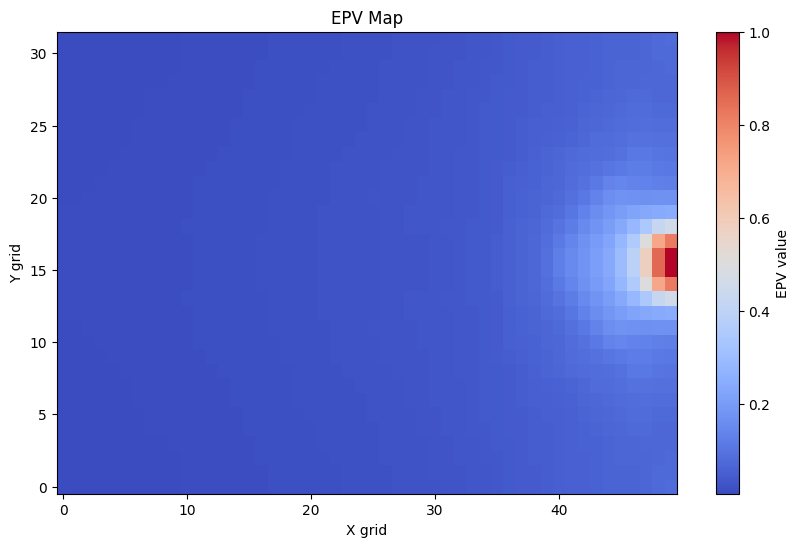

array([[0.0080504 , 0.0080504 , 0.00787539, ..., 0.0679034 , 0.07420371,
        0.07752888],
       [0.00770039, 0.00770039, 0.00787539, ..., 0.0679034 , 0.07367868,
        0.07647882],
       [0.00717536, 0.00735037, 0.00770039, ..., 0.0679034 , 0.07227861,
        0.07437872],
       ...,
       [0.00717536, 0.00735037, 0.00770039, ..., 0.0679034 , 0.07227861,
        0.07437872],
       [0.00770039, 0.00770039, 0.00787539, ..., 0.0679034 , 0.07367868,
        0.07647882],
       [0.0080504 , 0.0080504 , 0.00787539, ..., 0.0679034 , 0.07420371,
        0.07752888]])

In [17]:
# load control and transition model
EPV = mepv.load_EPV_grid('EPV_grid.csv')
EPV = EPV / np.max(EPV)
print(EPV.shape)

plt.figure(figsize=(10, 6))
plt.imshow(EPV, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(label='EPV value')
plt.title("EPV Map")
plt.xlabel("X grid")
plt.ylabel("Y grid")
plt.show()

EPV

(64, 100)


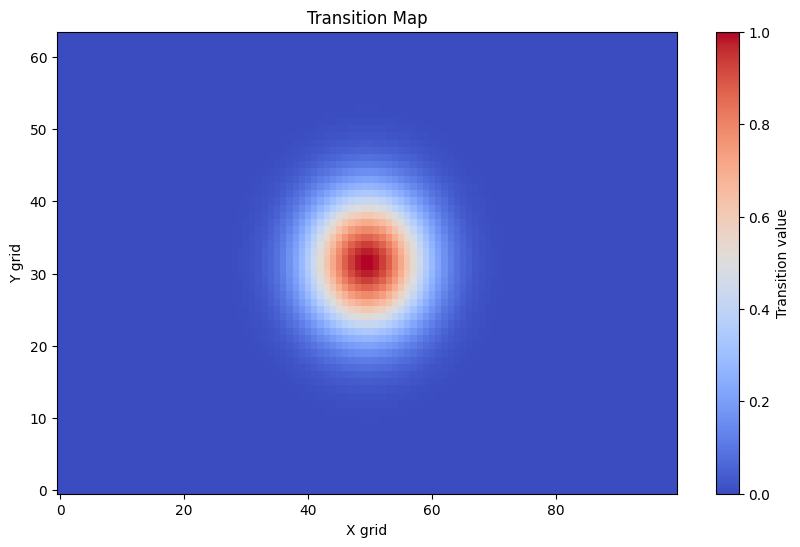

array([[4.62490081e-18, 1.42440623e-17, 4.28741258e-17, ...,
        4.28741258e-17, 1.42440623e-17, 4.62490081e-18],
       [9.66502860e-18, 2.97669670e-17, 8.95975219e-17, ...,
        8.95975219e-17, 2.97669670e-17, 9.66502860e-18],
       [1.97232298e-17, 6.07448517e-17, 1.82839864e-16, ...,
        1.82839864e-16, 6.07448517e-17, 1.97232298e-17],
       ...,
       [1.97232298e-17, 6.07448517e-17, 1.82839864e-16, ...,
        1.82839864e-16, 6.07448517e-17, 1.97232298e-17],
       [9.66502860e-18, 2.97669670e-17, 8.95975219e-17, ...,
        8.95975219e-17, 2.97669670e-17, 9.66502860e-18],
       [4.62490081e-18, 1.42440623e-17, 4.28741258e-17, ...,
        4.28741258e-17, 1.42440623e-17, 4.62490081e-18]])

In [18]:
Trans_df = pd.read_csv('Transition_gauss.csv', header=None)
Trans = np.array((Trans_df))
Trans = Trans / np.max(Trans)

print(Trans.shape)

plt.figure(figsize=(10, 6))
plt.imshow(Trans, cmap='coolwarm', origin='lower', aspect='auto')
plt.colorbar(label='Transition value')
plt.title("Transition Map")
plt.xlabel("X grid")
plt.ylabel("Y grid")
plt.show()

Trans

In [19]:
filtered_Metrica_df = Metrica_df[Metrica_df["Start X"].notna()].reset_index(drop=True).head(3)
filtered_Metrica_df

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,-5.25,7.48,5.25,4.76
1,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,5.25,4.76,8.40,19.72
2,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,5.25,21.08,-5.25,12.92


### 이벤트 단위의 OBSO 분석

In [54]:
obso = np.zeros((len(filtered_Metrica_df), 32, 50))
for event_num, frame in tqdm(enumerate(filtered_Metrica_df['Start Frame'])):
    
    if filtered_Metrica_df['Team'].loc[event_num]=='Home':
        # check attack direction 1st half or 2nd half
        if filtered_Metrica_df.loc[event_num]['Period']==1:
            direction = mio.find_playing_direction(tracking_home[tracking_home['Period']==1], 'Home')
        elif filtered_Metrica_df.loc[event_num]['Period']==2:
            direction = mio.find_playing_direction(tracking_home[tracking_home['Period']==2], 'Home')
        PPCF, _, _ = mpc.generate_pitch_control_for_event(event_num, frame, filtered_Metrica_df.loc[event_num], tracking_home, tracking_away, params, GK_numbers, offsides=True)
    elif filtered_Metrica_df['Team'].loc[event_num]=='Away': 
        # check attack direction 1st half or 2nd half
        if filtered_Metrica_df.loc[event_num]['Period']==1:
            direction = mio.find_playing_direction(tracking_away[tracking_away['Period']==1], 'Away')
        elif filtered_Metrica_df.loc[event_num]['Period']==2:
            direction = mio.find_playing_direction(tracking_away[tracking_away['Period']==2], 'Away')
        PPCF, _, _ = mpc.generate_pitch_control_for_event(event_num, frame, filtered_Metrica_df.loc[event_num], tracking_home, tracking_away, params, GK_numbers, offsides=True)
    else:
        obso[event_num] = np.zeros((32, 50))
        continue
    obso[event_num], _, _, _ = obs.calc_obso(PPCF, Trans, EPV, tracking_home.loc[frame], attack_direction=direction)

print(obso.shape)
obso[event_num]

0it [00:00, ?it/s]

(3, 32, 50)


array([[5.18231464e-14, 4.80531739e-13, 4.69994710e-12, ...,
        4.42661791e-08, 2.85901718e-08, 1.76541230e-08],
       [2.96565763e-14, 2.58049430e-13, 2.40422559e-12, ...,
        8.02080169e-08, 4.95515624e-08, 3.05975558e-08],
       [1.95215276e-14, 1.63274508e-13, 1.45947604e-12, ...,
        1.38764334e-07, 8.36900600e-08, 5.04472884e-08],
       ...,
       [1.55747103e-09, 1.40733824e-08, 1.13983638e-07, ...,
        8.51631802e-05, 5.13627060e-05, 3.09607765e-05],
       [4.36741705e-09, 3.54506112e-08, 2.23795387e-07, ...,
        7.91969378e-05, 4.89269297e-05, 3.02118518e-05],
       [1.24073371e-08, 8.80150397e-08, 4.29803046e-07, ...,
        7.03200613e-05, 4.54175780e-05, 2.80448649e-05]])

In [55]:
home_traces = tracking_home.copy()

x_cols = [col for col in home_traces.columns if "_x" in col]
y_cols = [col for col in home_traces.columns if "_y" in col]
home_traces[x_cols] += 52.5
home_traces[y_cols] += 34

home_traces[x_cols + y_cols + ["Period", "Time [s]"]]

,Home_11_x,Home_1_x,Home_2_x,Home_3_x,Home_4_x,Home_5_x,Home_6_x,Home_7_x,Home_8_x,Home_9_x,...,Home_7_y,Home_8_y,Home_9_y,Home_10_y,Home_12_y,Home_13_y,Home_14_y,ball_y,Period,Time [s]
Frame,,,,,,,,,,,,,,,,,,,,,
1,0.08610,34.28040,35.38605,32.47335,33.74385,43.14870,43.78290,41.08125,47.65740,55.33185,...,45.86600,53.60168,42.17360,38.57708,NaN,NaN,NaN,41.67788,1,0.04
2,0.10080,34.28040,35.38605,32.47335,33.74385,43.14870,43.78290,41.08125,47.65740,55.33185,...,45.86600,53.60168,42.17360,38.57708,NaN,NaN,NaN,40.35392,1,0.08
3,0.11970,34.28040,35.38605,32.47335,33.74385,43.14870,43.78290,41.08125,47.65740,55.33185,...,45.86600,53.60168,42.17360,38.57708,NaN,NaN,NaN,39.06192,1,0.12
4,0.12705,34.25310,35.37135,32.49120,33.74910,43.12035,43.78815,41.09070,47.64795,55.36755,...,45.85512,53.68396,42.15320,38.54716,NaN,NaN,NaN,39.28292,1,0.16
5,0.13545,34.22685,35.34720,32.49540,33.74280,43.11825,43.76610,41.09805,47.64480,55.37385,...,45.94964,53.75400,42.16612,38.54852,NaN,NaN,NaN,40.41240,1,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,9.85530,NaN,69.13515,72.21060,93.00060,77.89110,NaN,65.73210,86.68485,87.49335,...,42.46328,56.68140,52.18320,NaN,46.45148,44.46520,43.92664,NaN,2,5800.08
145003,9.92250,NaN,69.16665,72.20850,93.00060,77.91105,NaN,65.73210,86.70060,87.48705,...,42.46328,56.69296,52.14580,NaN,46.45148,44.47064,43.91644,NaN,2,5800.12
145004,9.98340,NaN,69.20655,72.22530,93.00060,77.95515,NaN,65.73210,86.72895,87.49650,...,42.46328,56.70928,52.14036,NaN,46.45148,44.44888,43.90692,NaN,2,5800.16


In [56]:
away_traces = tracking_away.copy()

x_cols = [col for col in away_traces.columns if "_x" in col]
y_cols = [col for col in away_traces.columns if "_y" in col]
away_traces[x_cols] += 52.5
away_traces[y_cols] += 34

away_traces = away_traces.drop(columns=["Period", "Time [s]", "ball_x", "ball_y"])
away_traces

,Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,Away_18_x,Away_18_y,...,Away_25_speed,Away_26_vx,Away_26_vy,Away_26_speed,Away_27_vx,Away_27_vy,Away_27_speed,Away_28_vx,Away_28_vy,Away_28_speed
Frame,,,,,,,,,,,,,,,,,,,,,
1,95.03445,35.72584,61.31265,53.86008,71.04090,36.23720,70.67550,15.99632,42.82215,26.16300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,95.01870,35.72584,61.31265,53.86008,71.04090,36.23720,70.67550,15.99632,42.82215,26.16300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,94.95570,35.72516,61.31265,53.86008,71.04090,36.23720,70.67550,15.99632,42.82215,26.16300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,94.89585,35.72516,61.26855,53.80976,71.02200,36.20184,70.64295,15.95144,42.80955,26.17660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,94.84020,35.72448,61.20555,53.69348,70.97895,36.19708,70.61565,15.93648,42.77280,26.19972,...,1.130387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,91.80780,37.66248,86.23020,38.64168,77.89110,40.76736,94.62600,62.82588,82.70325,52.62588,...,0.000000,0.292500,-0.859714,0.908111,0.307500,0.208857,0.371722,0.0,0.0,0.0
145003,91.80780,37.66248,86.27010,38.57436,77.91105,40.79932,94.62600,62.82588,82.70325,52.62588,...,0.000000,0.442500,-0.454143,0.634076,0.356250,0.568286,0.670718,0.0,0.0,0.0
145004,91.80780,37.66248,86.31840,38.54376,77.95515,40.81292,94.62600,62.82588,82.70325,52.62588,...,0.000000,0.609375,-0.057071,0.612042,0.467813,0.854857,0.974489,0.0,0.0,0.0


In [57]:
traces = pd.concat([home_traces, away_traces], axis=1).reset_index(drop=False)
traces = traces[sorted(traces.columns)]
traces.columns = traces.columns.str.replace('Home', 'H', regex=False)
traces.columns = traces.columns.str.replace('Away', 'A', regex=False)
traces.columns = traces.columns.str.replace('ball', 'B00', regex=False)
traces

,A_15_speed,A_15_vx,A_15_vy,A_15_x,A_15_y,A_16_speed,A_16_vx,A_16_vy,A_16_x,A_16_y,...,H_8_y,H_9_speed,H_9_vx,H_9_vy,H_9_x,H_9_y,Period,Time [s],B00_x,B00_y
0,NaN,NaN,NaN,61.31265,53.86008,NaN,NaN,NaN,71.04090,36.23720,...,53.60168,NaN,NaN,NaN,55.33185,42.17360,1,0.04,47.74560,41.67788
1,NaN,NaN,NaN,61.31265,53.86008,NaN,NaN,NaN,71.04090,36.23720,...,53.60168,NaN,NaN,NaN,55.33185,42.17360,1,0.08,52.12725,40.35392
2,NaN,NaN,NaN,61.31265,53.86008,NaN,NaN,NaN,71.04090,36.23720,...,53.60168,NaN,NaN,NaN,55.33185,42.17360,1,0.12,56.40180,39.06192
3,NaN,NaN,NaN,61.26855,53.80976,NaN,NaN,NaN,71.02200,36.20184,...,53.68396,NaN,NaN,NaN,55.36755,42.15320,1,0.16,58.11330,39.28292
4,1.543505,-1.22250,-0.942286,61.20555,53.69348,1.021769,-0.945000,0.388571,70.97895,36.19708,...,53.75400,1.313156,0.206250,1.296857,55.37385,42.16612,1,0.20,58.28760,40.41240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145001,1.376346,0.72000,-1.173000,86.23020,38.64168,0.923588,0.337500,0.859714,77.89110,40.76736,...,56.68140,0.617189,-0.277500,-0.551286,87.49335,52.18320,2,5800.08,NaN,NaN
145002,1.205484,0.83250,-0.871857,86.27010,38.57436,0.885879,0.626250,0.626571,77.91105,40.79932,...,56.69296,0.731961,0.037500,-0.731000,87.48705,52.14580,2,5800.12,NaN,NaN
145003,1.216872,1.03875,-0.633857,86.31840,38.54376,1.045016,0.917813,0.499679,77.95515,40.81292,...,56.70928,0.903031,0.391875,-0.813571,87.49650,52.14036,2,5800.16,NaN,NaN
145004,1.306418,1.24500,-0.395857,86.38350,38.50228,1.265526,1.209375,0.372786,77.99295,40.86052,...,56.73240,1.166174,0.746250,-0.896143,87.53010,52.13220,2,5800.20,NaN,NaN


0 0.027519764235853447


0it [00:00, ?it/s]

vmin: 0.0, vmax:  0.0271
vmin: 0.0, vmax:  0.0215
vmin: 0.0, vmax:  0.0184


,A_15_x,A_16_x,A_17_x,A_18_x,A_19_x,A_20_x,A_21_x,A_22_x,A_23_x,A_24_x,...,H_1_y,H_2_y,H_3_y,H_4_y,H_5_y,H_6_y,H_7_y,H_8_y,H_9_y,B00_y
0,61.31265,71.04090,70.67550,42.82215,47.7456,58.7580,58.00515,52.57035,45.87765,39.72465,...,23.58104,34.77316,43.84028,53.54184,18.63948,35.46676,45.86600,53.60168,42.17360,41.67788
1,61.31265,71.04090,70.67550,42.82215,47.7456,58.7580,58.00515,52.57035,45.87765,39.72465,...,23.58104,34.77316,43.84028,53.54184,18.63948,35.46676,45.86600,53.60168,42.17360,40.35392
2,61.31265,71.04090,70.67550,42.82215,47.7456,58.7580,58.00515,52.57035,45.87765,39.72465,...,23.58104,34.77316,43.84028,53.54184,18.63948,35.46676,45.86600,53.60168,42.17360,39.06192
3,61.26855,71.02200,70.64295,42.80955,47.7267,58.7727,57.99780,52.53570,45.82620,39.64380,...,23.58444,34.68816,43.82328,53.55612,18.65580,35.38380,45.85512,53.68396,42.15320,39.28292
4,61.20555,70.97895,70.61565,42.77280,47.6973,58.7916,57.96210,52.51785,45.75900,39.54615,...,23.61708,34.66776,43.84096,53.61188,18.69320,35.39264,45.94964,53.75400,42.16612,40.41240


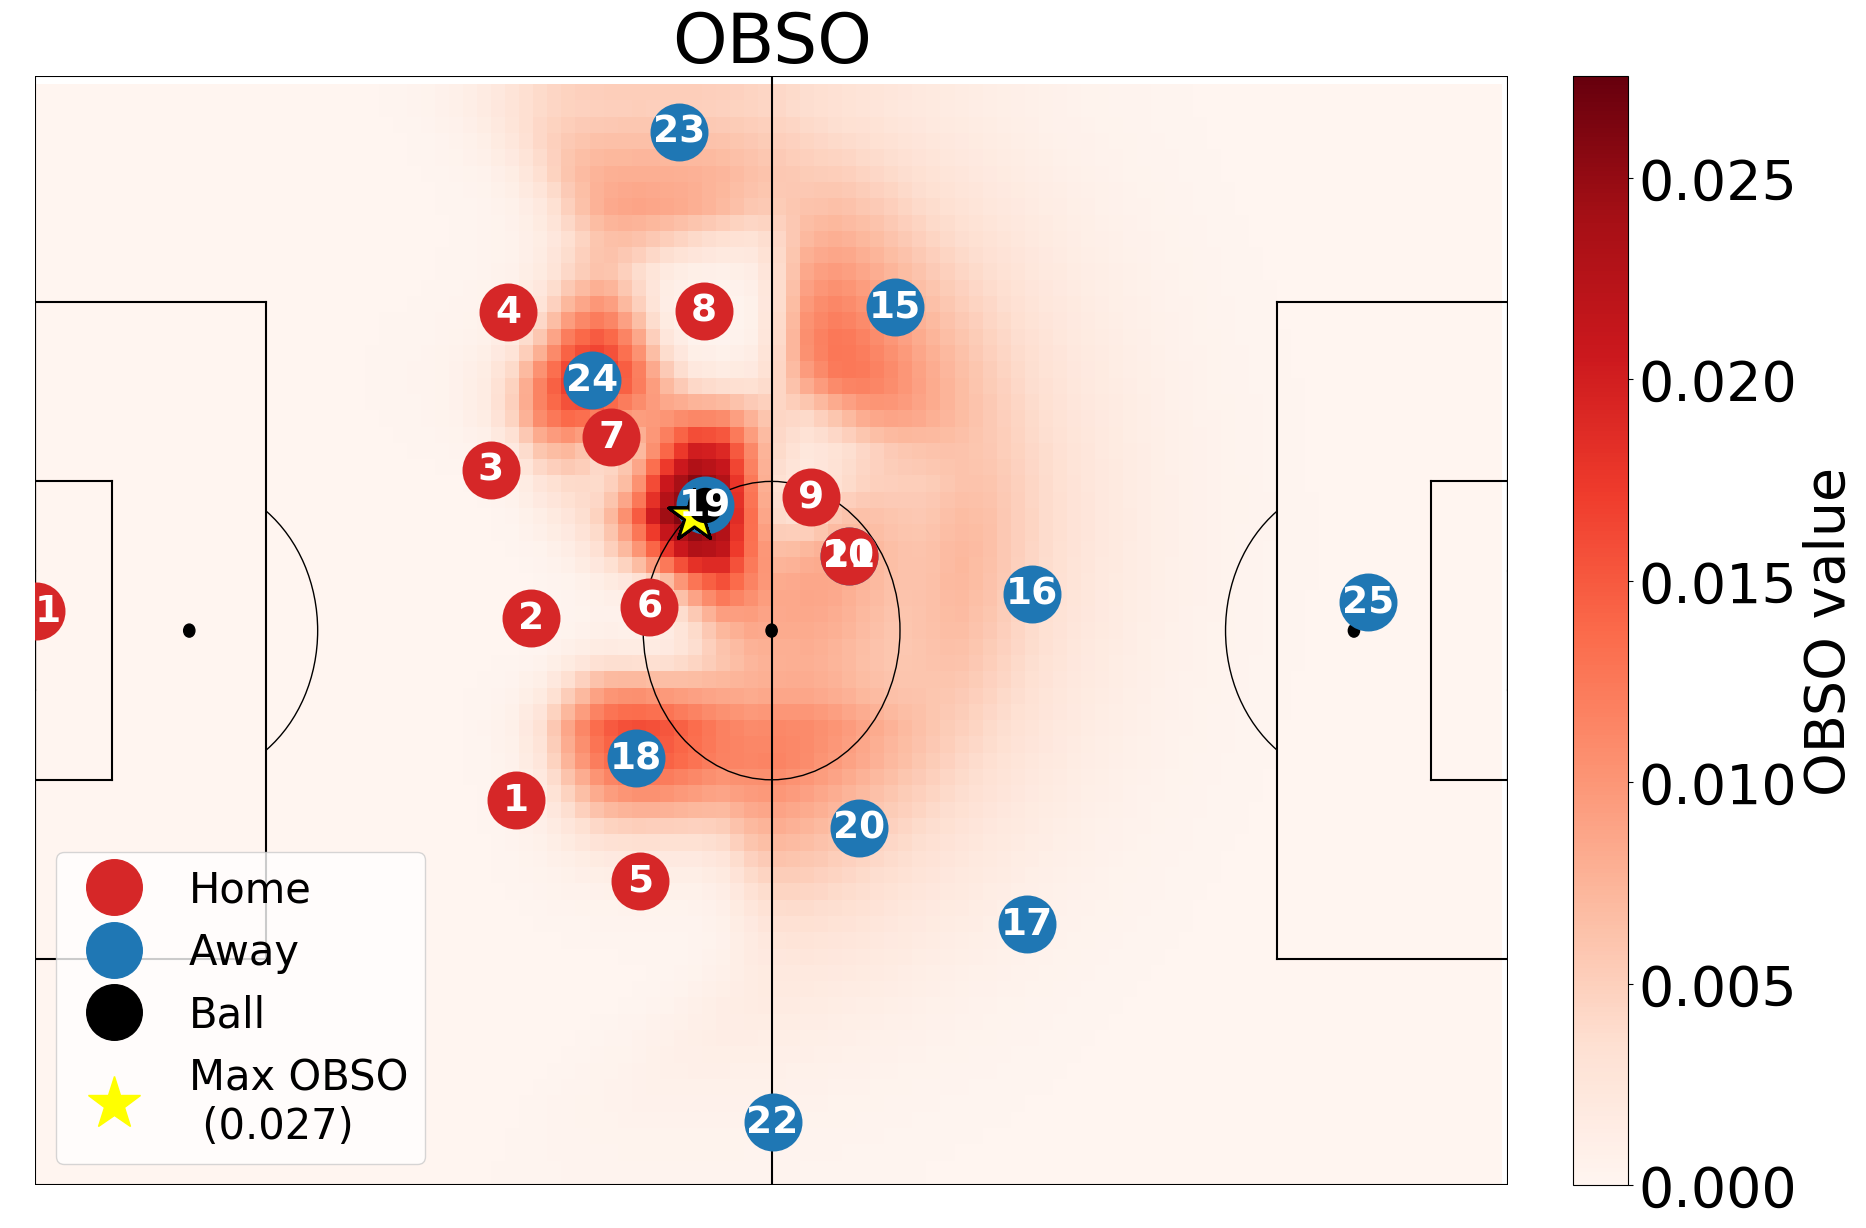

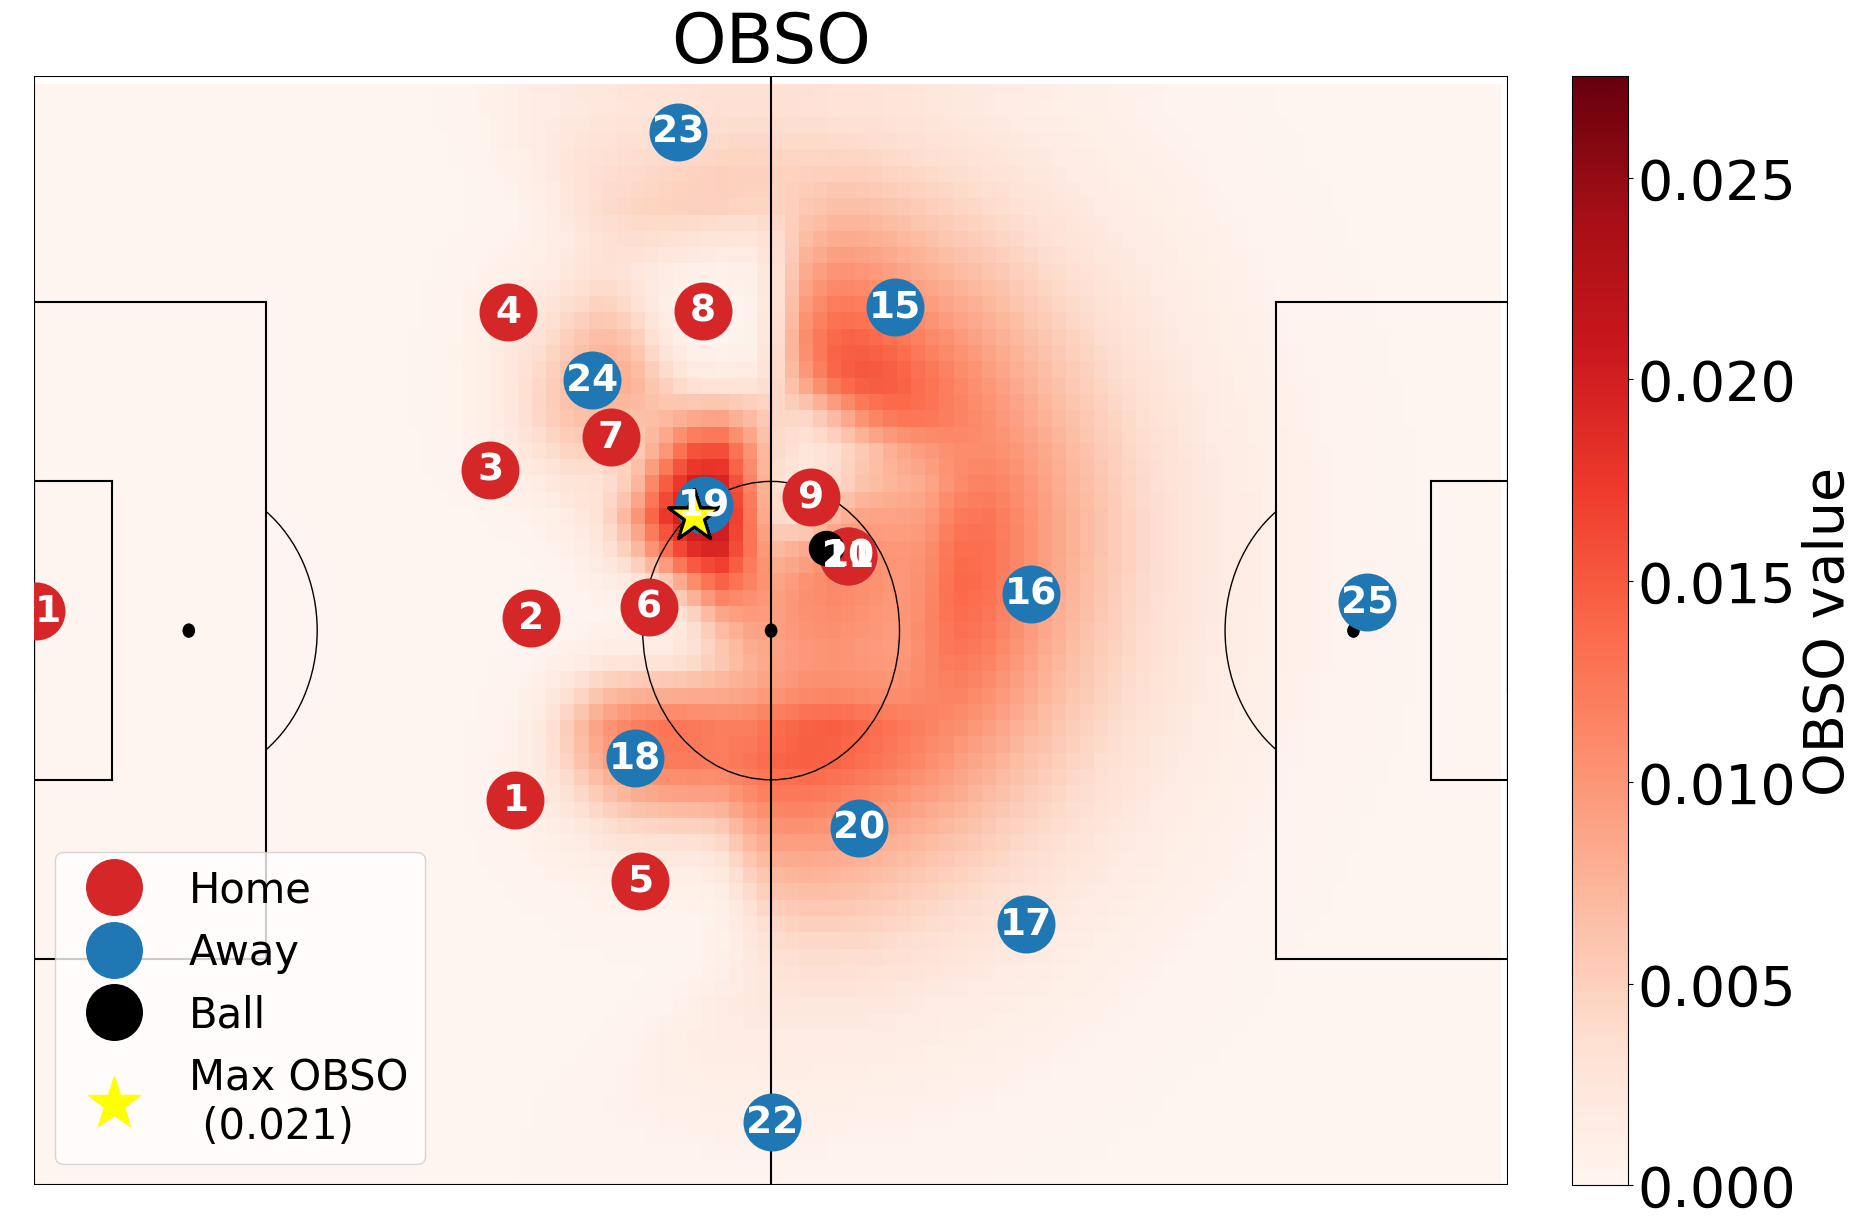

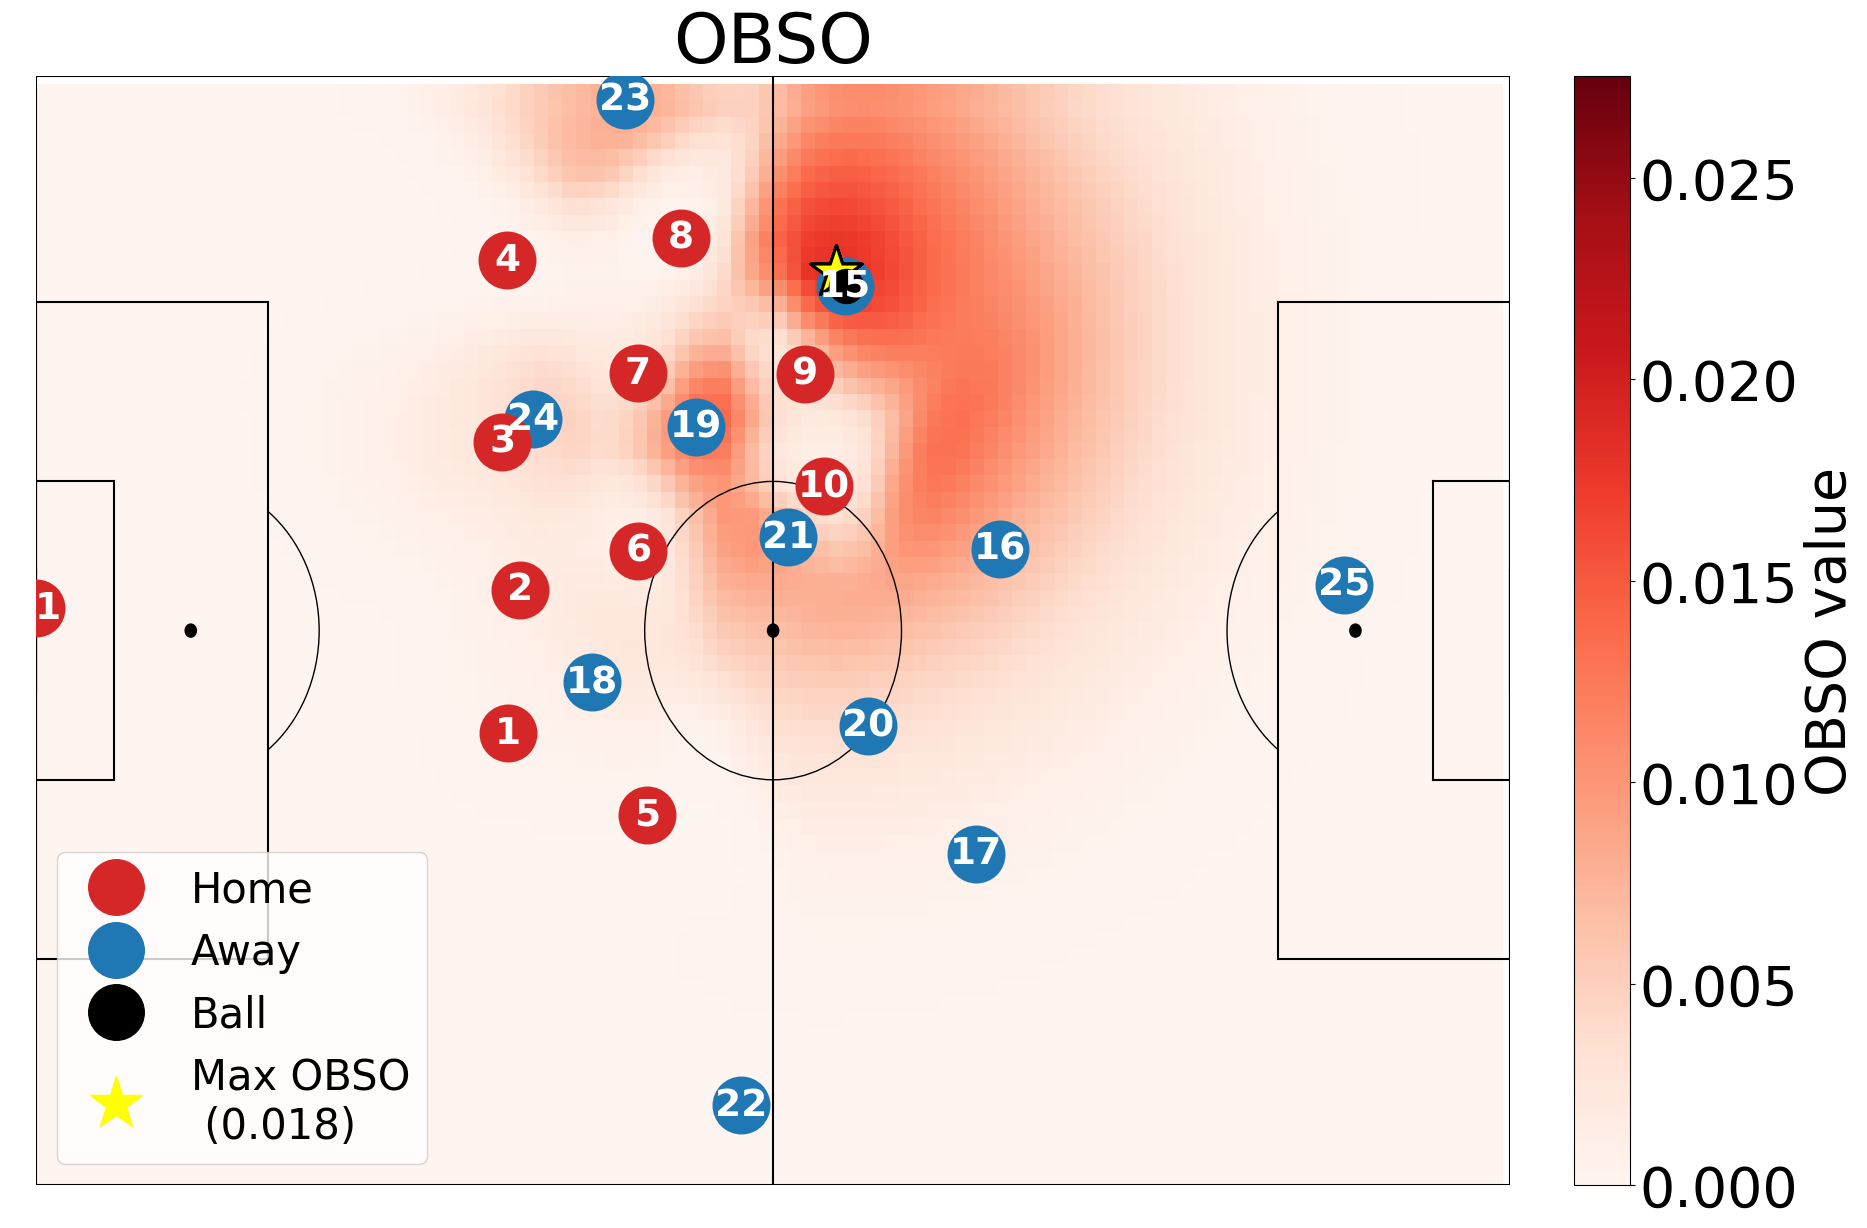

In [58]:
vmin = 0
vmax = np.max(obso)
print(vmin, vmax)
for event_num, frame in tqdm(enumerate(filtered_Metrica_df['Start Frame'])):
    trace = traces[traces["Frame"] == frame].reset_index(drop=True)
 
    snapshot = TraceSnapshot(trace, play_left_to_right=False)
    fig, ax = snapshot.plot(color="white", obso=obso[event_num], vmin=vmin, vmax=vmax)
 
x_cols = [col for col in trace.columns if "_x" in col]
y_cols = [col for col in trace.columns if "_y" in col]
traces[x_cols+y_cols].head()

### Frame 단위의 OBSO 분석

In [72]:
event_id = 2
Metric_row = Metrica_df.loc[event_id]
before_frame, after_frame = Metric_row['Start Frame'] - 5, Metric_row['End Frame'] + 5
before_frame = max(before_frame, traces['Frame'].min())
after_frame = min(after_frame, traces['Frame'].max())
before_frame, after_frame = int(before_frame), int(after_frame)
print(before_frame, after_frame)

1 22


In [74]:
obso = np.zeros((after_frame-before_frame+1, 32, 50))
ppcf = np.zeros((after_frame-before_frame+1, 32, 50))
transition = np.zeros((after_frame-before_frame+1, 32, 50))
score = np.zeros((after_frame-before_frame+1, 32, 50))

for i, frame in enumerate(tqdm(range(before_frame, after_frame+1))):
    if Metric_row.Team == 'Home':
        # check attack direction 1st half or 2nd half
        if Metric_row.Period==1:
            direction = mio.find_playing_direction(tracking_home[tracking_home['Period']==1], 'Home')
        elif Metric_row.Period == 2:
            direction = mio.find_playing_direction(tracking_home[tracking_home['Period']==2], 'Home')

        PPCF, _, _ = mpc.generate_pitch_control_for_event(event_id, frame, Metric_row, tracking_home, tracking_away, params, GK_numbers, offsides=True, field_dimen=(105,68))
    elif Metric_row.Team == 'Away': 
        # check attack direction 1st half or 2nd half
        if Metric_row.Period == 1:
            direction = mio.find_playing_direction(tracking_away[tracking_away['Period']==1], 'Away')
        elif Metric_row.Period == 2:
            direction = mio.find_playing_direction(tracking_away[tracking_away['Period']==2], 'Away')

        PPCF, _, _ = mpc.generate_pitch_control_for_event(event_id, frame, Metric_row, tracking_home, tracking_away, params, GK_numbers, offsides=True, field_dimen=(105,68))
    else:
        print("No team data")
        obso[i] = np.zeros((32, 50))
        continue
    
    obso[i], ppcf[i], transition[i], score[i] = obs.calc_obso(PPCF, Trans, EPV, tracking_home.loc[frame], attack_direction=direction)

  0%|          | 0/22 [00:00<?, ?it/s]

max_value: 0.027121566437630813


0it [00:00, ?it/s]

vmin: 0.0, vmax:  0.0268


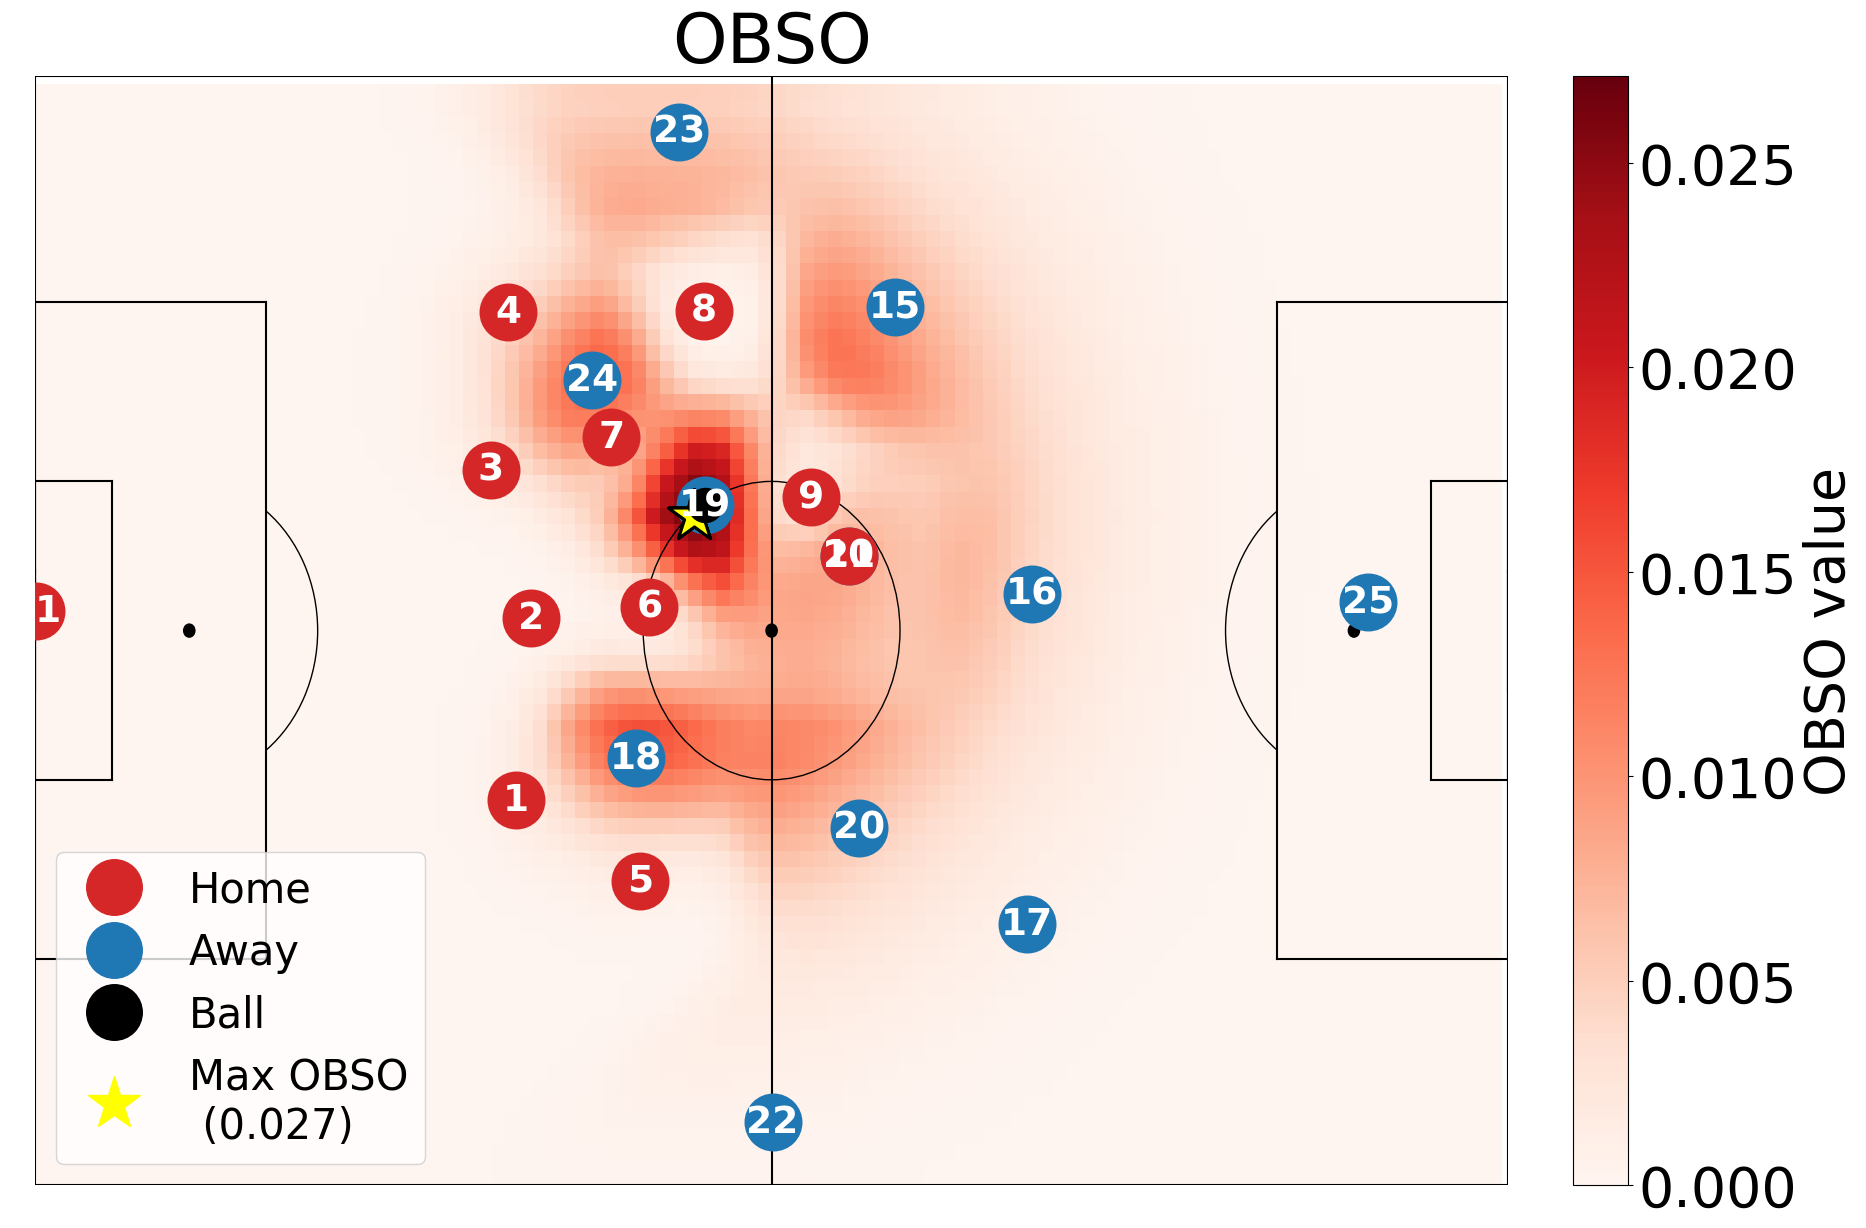

vmin: 0.0, vmax:  0.0251


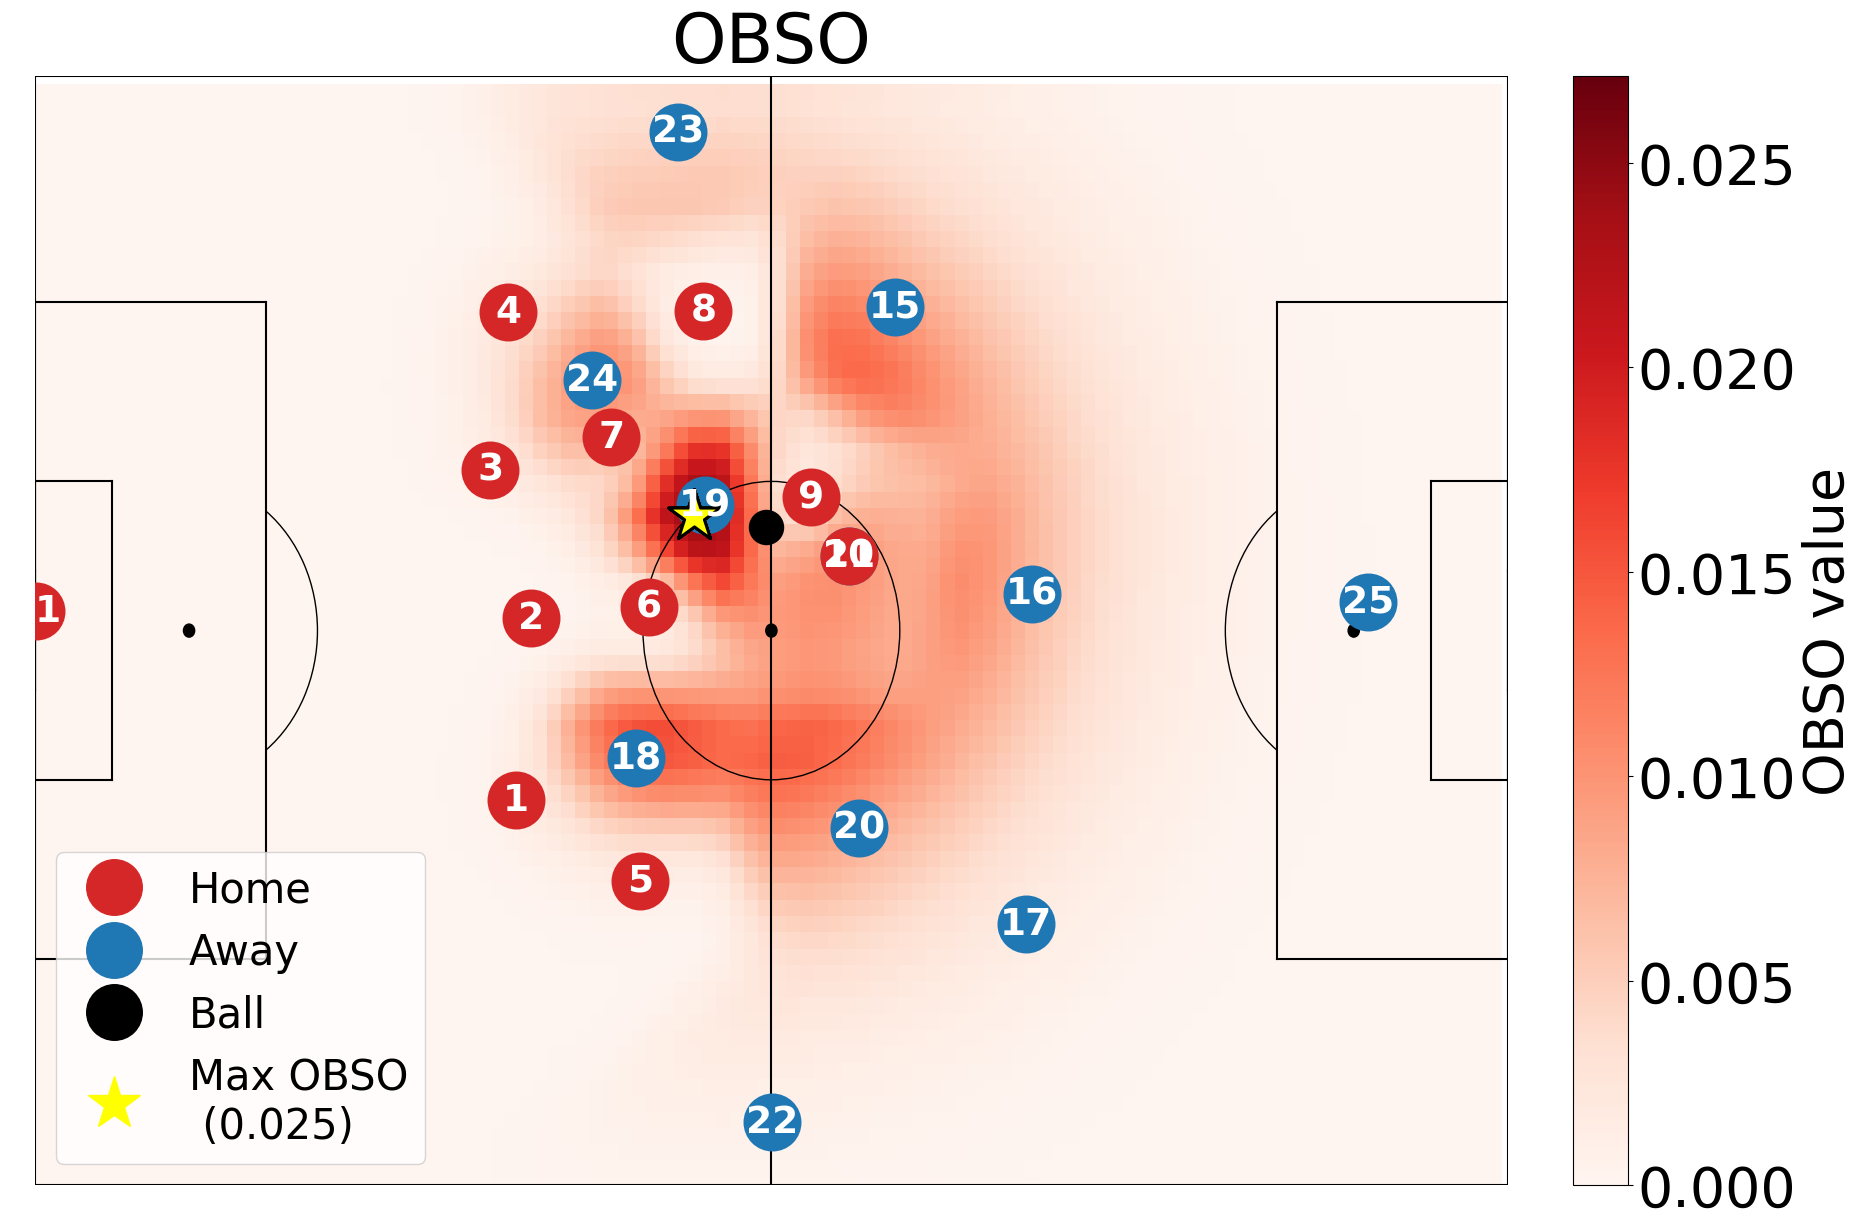

vmin: 0.0, vmax:  0.0215


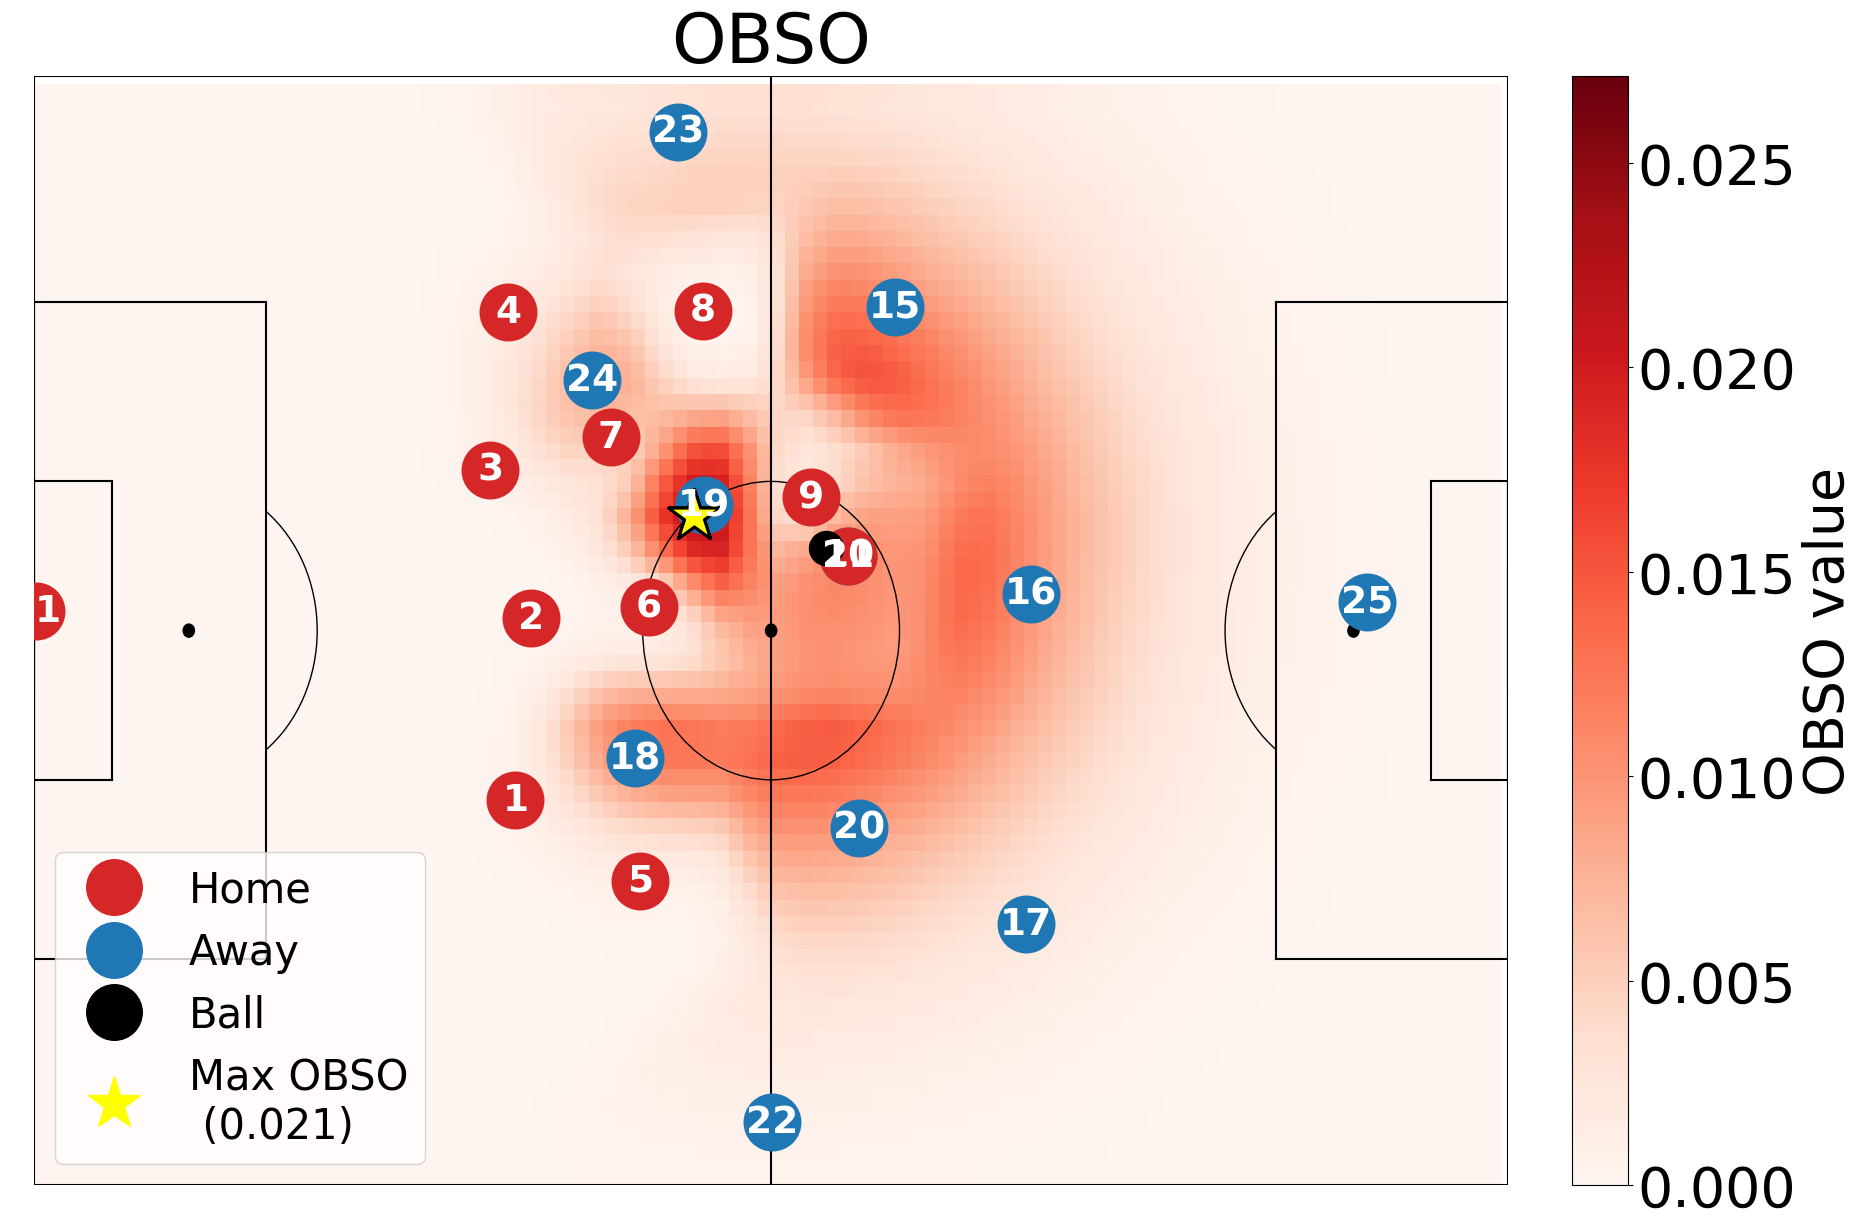

vmin: 0.0, vmax:  0.0194
vmin: 0.0, vmax:  0.0191
vmin: 0.0, vmax:  0.0189
vmin: 0.0, vmax:  0.0190
vmin: 0.0, vmax:  0.0175
vmin: 0.0, vmax:  0.0186
vmin: 0.0, vmax:  0.0184
vmin: 0.0, vmax:  0.0192
vmin: 0.0, vmax:  0.0189
vmin: 0.0, vmax:  0.0196
vmin: 0.0, vmax:  0.0195
vmin: 0.0, vmax:  0.0199
vmin: 0.0, vmax:  0.0198
vmin: 0.0, vmax:  0.0198
vmin: 0.0, vmax:  0.0197
vmin: 0.0, vmax:  0.0196
vmin: 0.0, vmax:  0.0196
vmin: 0.0, vmax:  0.0195
vmin: 0.0, vmax:  0.0194


In [78]:
save_dir = "./obso"
os.makedirs(save_dir, exist_ok=True)

value = obso # obso, ppcf, transition, score 중 선택
max_value = np.max(value)
print(f"max_value: {max_value}")
for event_num, frame in tqdm(enumerate(range(before_frame, after_frame + 1))):
    trace = traces[traces["Frame"] == frame]
 
    snapshot = TraceSnapshot(trace, play_left_to_right=False)
    fig, ax = snapshot.plot(color="white", obso=value[event_num], vmin=0, vmax=max_value)

    if event_num < 3: # 일부만 show
        plt.show()
    else:
        plt.close(fig)
  
    save_path = os.path.join(save_dir, f"frame_{event_num:03d}.png")
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

In [81]:
frame_paths = sorted(glob.glob("./obso/frame_*.png"))

frames = [plt.imread(fp) for fp in frame_paths]
h, w, _ = frames[0].shape
fig, ax = plt.subplots(figsize=(w/100, h/100), dpi=100)
ax.axis("off")
im = ax.imshow(frames[0])


def update(i):
    im.set_array(frames[i])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)
ani.save(
    "animation.mp4",
    writer="ffmpeg",
    fps=25,
    dpi=100,
    codec='libx264',
    extra_args=['-pix_fmt', 'yuv420p']
)
plt.close(fig)